# From Lab  to Lecture: 

## Analyzing the Connection Between Professors’ Research and Course Content​ 👩‍🏫

**Authors**:
- Erik Wold Riise, s194633​
- Lukas Rasocha, s233498​
- Zou Yong Nan Klaassen, s230351

![Intro Image](./assets/intro.png)


*Image Prompt: minimalistic network visualization with two nodes: one representing a professor and the other a course they teach, connected by a single edge*


### Data Overview 📊

We collected data from 3 separate sources. The first source is the dtu course base from which we gathered information about the courses and the professors teaching them (including the grades, ratings, descriptions, prerequisites, etc.). The second source is the dtu orbit database, which contains information about the professors and their research from which we scraped all the necessary fields for each professor. The third source is a platform called scholia, which contains additional information about the professors and their research. We used this data to create a bipartite bipartite bipartite bipartite bipartite bipartite bipartite bipartite bipartite network of professors and courses, where the nodes are the professors and the courses they teach, and the edges are the connections between them. 

### Project Overview ✍️

This project investigates the alignment between professors’ research areas and the courses they teach through the angle of network analysis and natural language processing (NLP).
We plan to construct a bipartite graph of professors and courses, and analyze the structural and thematic patterns in teaching and research connections.

The central research question steering the project is:
_"How well do professors’ research areas align with the content and objectives of the courses they teach, and how does this alignment vary across disciplines?"_

To complement this, we also examine:
_"Does the alignment between professors’ research and the courses they teach influence student satisfaction and performance (grades)?"_

Using NLP techniques, we analyze course descriptions and research topics to measure alignment, and we relate these findings to course evaluations and grades. Additionally, network analysis methods, such as community detection and centrality measures, will be applied to uncover interdisciplinary trends and the influence of professors within the academic network.

By this we hope to shed light on how expertise and teaching intersect, and how does that impact educational outcomes in a broader sense.

### Research Directions

- Does the alignment between professors’ research and the courses they teach influence student satisfaction and performance (grades)?

- How well do professors’ research areas align with the content and objectives of the courses they teach, and how does this alignment vary across disciplines?

- In a situation where a professor quits, how can we find a suitable replacement based on the research areas of the professor and the courses they teach?


### Imports

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import random
import statistics

import os
import json

from tqdm import tqdm
from bs4 import BeautifulSoup
from scholia import query as scholia_query
from SPARQLWrapper import SPARQLWrapper, JSON
from networkx.drawing.layout import bipartite_layout

## Data acquisition

### Load Course Data

In [8]:
file_path = 'data/course_df.csv'
course_df = pd.read_csv(file_path)

### DTU Orbit Scraper class + Scholia API

In [9]:

class DTUOrbitScraper:
    def __init__(self):
        self.base_url = "https://orbit.dtu.dk/en/persons/"
        self.endpoint_url = "https://query.wikidata.org/sparql"

    def search_person(self, name):
        """Search for the person and get the URL to their profile."""
        search_url = f"{self.base_url}?search={name.replace(' ', '+')}&isCopyPasteSearch=false"
        response = requests.get(search_url)
        
        if response.status_code != 200:
            raise Exception("Failed to fetch search results")
        
        soup = BeautifulSoup(response.text, "html.parser")
        # Find the first profile link (assuming it's the first result)
        profile_link = soup.find("h3", class_="title").find("a", href=True)
        
        if profile_link:
            return profile_link['href']
        else:
            raise Exception("Profile link not found")

    def get_topic_info(self, topic_url):
        """Scrape the description for a topic from its Wikidata page."""
        response = requests.get(topic_url)
        if response.status_code != 200:
            return "Description not found"
        
        soup = BeautifulSoup(response.text, "html.parser")
        description = soup.find("div", class_="wikibase-entitytermsview-heading-description")
        return description.text.strip() if description else "Description not found"

    def get_scholia_topics(self, qs):
        """Get topics and scores from Scholia using SPARQL."""
        query = f"""PREFIX target: <http://www.wikidata.org/entity/{qs}>
        SELECT ?score ?topic ?topicLabel
        WITH {{
            SELECT (SUM(?score_) AS ?score) ?topic WHERE {{
                {{ target: wdt:P101 ?topic . BIND(20 AS ?score_) }}
                UNION {{ SELECT (3 AS ?score_) ?topic WHERE {{ ?work wdt:P50 target: ; wdt:P921 ?topic . }} }}
                UNION {{ SELECT (1 AS ?score_) ?topic WHERE {{ ?work wdt:P50 target: . ?citing_work wdt:P2860 ?work . ?citing_work wdt:P921 ?topic . }} }}
            }} GROUP BY ?topic
        }} AS %results 
        WHERE {{
            INCLUDE %results
            SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}
        }}
        ORDER BY DESC(?score)
        LIMIT 200"""
        
        sparql = SPARQLWrapper(self.endpoint_url)
        sparql.setQuery(query)
        sparql.setReturnFormat(JSON)
        results = sparql.query().convert()
        
        topics = [] 

        for result in results["results"]["bindings"]:
            topic_url = result["topic"]["value"]
            topic_label = result["topicLabel"]["value"]
            score = int(result["score"]["value"])
            #info = self.get_topic_info(topic_url)
            #topics[topic_label] = {"score": score, "info": info}
            topics.append({"topic":topic_label, "score": score, "topic_url": topic_url})
        return topics

    def get_profile_info(self, name):
        """Retrieve profile information given a person's name."""
        full_profile_url = self.search_person(name)
        response = requests.get(full_profile_url)
        
        if response.status_code != 200:
            raise Exception("Failed to fetch profile page")
        
        soup = BeautifulSoup(response.text, "html.parser")
        
        # Extract profile information
        profile_info = {}
        
        # Get Profile Description
        profile_header = soup.find("h3", string="Profile")
        profile_section = profile_header.find_next("p") if profile_header else None
        profile_info["Profile_desc"] = profile_section.get_text(strip=True) if profile_section else "None"
        
        # Get Keywords
        keywords_section = soup.find("div", class_="keyword-group")
        if keywords_section:
            keywords = [keyword.get_text(strip=True) for keyword in keywords_section.find_all("li", class_="userdefined-keyword")]
            profile_info["Keywords"] = keywords
        else:
            profile_info["Keywords"] = []

        # Get Fingerprint (Concepts, Thesauri, Values)
        fingerprints = []
        fingerprint_section = soup.find("div", class_="person-top-concepts")
        if fingerprint_section:
            fingerprint_items = fingerprint_section.find_all("li", class_="concept-badge-large-container")
            for item in fingerprint_items:
                concept = item.find("span", class_="concept").get_text(strip=True) if item.find("span", class_="concept") else "N/A"
                thesauri = item.find("span", class_="thesauri").get_text(strip=True) if item.find("span", class_="thesauri") else "N/A"
                value = item.find("span", class_="value sr-only").get_text(strip=True) if item.find("span", class_="value sr-only") else "N/A"
                fingerprints.append({
                    "Concept": concept,
                    "Thesauri": thesauri,
                    "Value": value
                })
        profile_info["Fingerprint"] = fingerprints

        # Extract ORCID
        orcid_section = soup.find("div", class_="rendering_person_personorcidrendererportal")
        if orcid_section:
            orcid_link = orcid_section.find("a", href=True)
            profile_info["ORCID"] = orcid_link["href"] if orcid_link else "Not found"
            if orcid_link:
                orcid_id = orcid_link["href"].split("/")[-1]
                profile_info["QS"] = scholia_query.orcid_to_qs(orcid_id)
                # Retrieve Scholia topics if QS exists
                if len(profile_info["QS"]) == 1:
                    profile_info["scholia_topics"] = self.get_scholia_topics(profile_info["QS"][0])
                else:
                    profile_info["scholia_topics"] = {}
        else:
            profile_info["ORCID"] = "Not found"
            profile_info["QS"] = "Not found"
            profile_info["scholia_topics"] = {}

        return profile_info

### Scrape Professors information

In [10]:
scraper = DTUOrbitScraper()

professor_columns = [
    "MAIN_RESPONSIBLE_NAME", "CO_RESPONSIBLE_1_NAME",
    "CO_RESPONSIBLE_2_NAME", "CO_RESPONSIBLE_3_NAME", "CO_RESPONSIBLE_4_NAME"
]

# Extract unique professors from the dataset
def extract_professors(dataframe, professor_columns):
    professors = set()
    for col in professor_columns:
        professors.update(dataframe[col].dropna().unique())
    return list(professors)


def scrape_professor_data(professors, output_file):
    if os.path.exists(output_file):
        print(f"File {output_file} already exists. Skipping scraping.")
        return

    all_data = {}

    for professor in tqdm(professors, desc="Scraping Professors"):
        if professor in all_data:
            print(f"Skipping {professor} as it already exists in the JSON file.")
            continue

        try:
            profile_info = scraper.get_profile_info(professor)
            all_data[professor] = profile_info  # Add to dictionary
        except Exception as e:
            print(f"Failed to scrape data for {professor}: {str(e)}")
            continue

    with open(output_file, "w") as f:
        json.dump(all_data, f, indent=4)
    
    print(f"Saved all professor data to {output_file}")


output_file = "data/all_professors.json"
professors = extract_professors(course_df, professor_columns)
scrape_professor_data(professors, output_file)

File data/all_professors.json already exists. Skipping scraping.


### Load Professors data

In [11]:
with open("data/all_professors.json", "r") as f:
    professors_data = json.load(f)

### Data Cleaning and Preprocessing
Write in more detail about your choices in data cleaning and preprocessing
Did you do analyses / calculate statistics that didn't make it to the main text, put them here.

In [12]:
print("Available information from the courses dataset:")
print(list(course_df.columns))
print("-" * 50)

print("Available information from the professors dataset:")
print(list(professors_data.values())[0].keys())
print("-" * 50)


print(f"Number of unique courses: {course_df['COURSE'].nunique()}")
professors = extract_professors(course_df, professor_columns)
print(f"Number of unique professors: {len(professors)}")

# Barchart one bar is number of unique courses and the other is number of unique professors
plt.figure(figsize=(4, 3))
plt.bar(["Courses", "Professors"], [course_df["COURSE"].nunique(), len(professors)], color=[BLUE, RED])
plt.title("Unique Courses and Professors")
plt.ylabel("Count")

Available information from the courses dataset:
['COURSE', 'NAME', 'DANISH_NAME', 'LANGUAGE', 'ECTS_POINTS', 'COURSE_TYPE', 'STUDENTS_PER_SEMESTER', 'SEMESTER_PERIOD', 'EXAM_TYPE', 'ASSIGNMENTS', 'TIME_OF_WEEK', 'LAST_UPDATED', 'GRADE_12', 'GRADE_10', 'GRADE_7', 'GRADE_4', 'GRADE_02', 'GRADE_00', 'GRADE_MINUS_3', 'PASSED', 'FAILED', 'ABSENT', 'AVERAGE_GRADE', 'TOTAL_STUDENTS', 'PERCENT_PASSED', 'PERCENT_FAILED', 'PERCENT_ABSENT', 'RATING_TIER', 'RATING_AVERAGE_SCORE', 'RATING_VOTES', 'LEARNING_TIER', 'LEARNING_AVERAGE_SCORE', 'LEARNING_VOTES', 'MOTIVATION_TIER', 'MOTIVATION_AVERAGE_SCORE', 'MOTIVATION_VOTES', 'FEEDBACK_TIER', 'FEEDBACK_AVERAGE_SCORE', 'FEEDBACK_VOTES', 'WORKLOAD_TIER', 'WORKLOAD_AVERAGE_SCORE', 'WORKLOAD_VOTES', 'WORKLOAD_4_STAR', 'WORKLOAD_5_STAR', 'MAIN_RESPONSIBLE_NAME', 'MAIN_RESPONSIBLE_PIC', 'CO_RESPONSIBLE_1_NAME', 'CO_RESPONSIBLE_1_PIC', 'CO_RESPONSIBLE_2_NAME', 'CO_RESPONSIBLE_2_PIC', 'CO_RESPONSIBLE_3_NAME', 'CO_RESPONSIBLE_3_PIC', 'CO_RESPONSIBLE_4_NAME', 'C

NameError: name 'BLUE' is not defined

<Figure size 400x300 with 0 Axes>

KeyError: 'count'

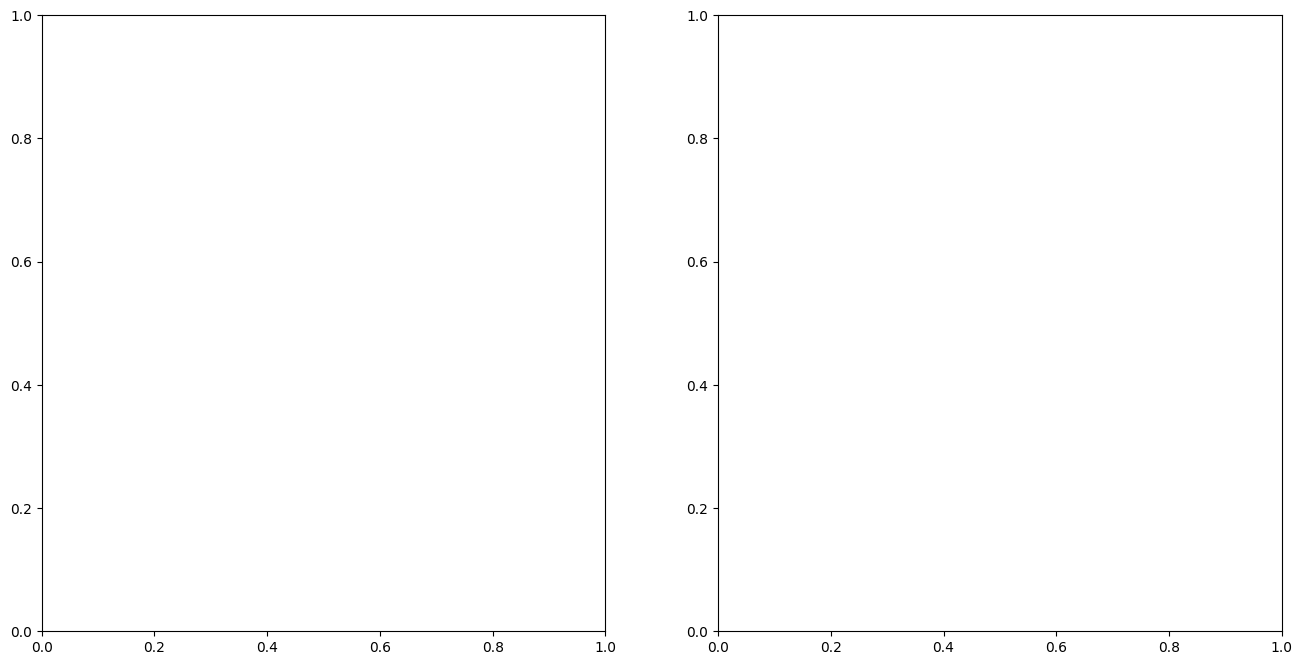

In [13]:
professors = extract_professors(course_df, professor_columns)

professor_course_counts = {}
for col in professor_columns:
    professor_course_counts.update(course_df[col].value_counts().to_dict())

# Create graph for professors
professor_graph = nx.Graph()
professor_graph.add_nodes_from(professors)
for professor, count in professor_course_counts.items():
    if professor != "NO_DATA":
        professor_graph.nodes[professor]["count"] = count

random_layout_professors = {professor: (random.uniform(0, 1), random.uniform(0, 1)) for professor in professors}

# Calculate the number of responsible names for each course
course_responsible_counts = course_df[professor_columns].apply(
    lambda row: sum(row != "NO_DATA"), axis=1
)

# Create graph for courses
courses = course_df["COURSE"].tolist()
course_graph = nx.Graph()
course_graph.add_nodes_from(courses)
for course, count in zip(courses, course_responsible_counts):
    course_graph.nodes[course]["count"] = count

random_layout_courses = {course: (random.uniform(0, 1), random.uniform(0, 1)) for course in courses}

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot professors graph
plt.sca(axes[0])
pos = nx.spring_layout(professor_graph)
nx.draw_networkx_nodes(
    professor_graph,
    pos,
    random_layout_professors,
    node_size=[professor_graph.nodes[prof]["count"] * 20 for prof in professor_graph.nodes],
    node_color=RED,
)
nx.draw_networkx_edges(professor_graph, random_layout_professors, alpha=0.5)
plt.title("Professors in the Dataset (size = number of courses taught)", fontsize=16)
plt.axis("off")

plt.sca(axes[1])
pos = nx.spring_layout(course_graph)
nx.draw_networkx_nodes(
    course_graph,
    pos,
    random_layout_courses,
    node_size=[course_graph.nodes[course]["count"] * 10 for course in course_graph.nodes],
    node_color=BLUE,
)
nx.draw_networkx_edges(course_graph, random_layout_courses, alpha=0.5)
plt.title("Courses in the Dataset (size = number of responsible professors)", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()

In [16]:
columns_to_plot = [
    "WORKLOAD_AVERAGE_SCORE",
    "FEEDBACK_AVERAGE_SCORE",
    "MOTIVATION_AVERAGE_SCORE",
    "LEARNING_AVERAGE_SCORE",
    "RATING_AVERAGE_SCORE",
    "AVERAGE_GRADE"
]
COLORS = [RED, BLUE, GREEN, ORANGE, PURPLE, NAVY]
scores = course_df.copy()

scores[columns_to_plot] = scores[columns_to_plot].replace(["No data", "Pass/Fail"], np.nan).astype(float)

# Create the 3x2 plot
plt.figure(figsize=(12, 8))
plt.suptitle("Histograms of Average Scores and Grades at DTU", fontsize=16, y=0.98)

# Histograms for the other columns
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(3, 2, i)
    plt.hist(scores[col].dropna(), bins=20, color=COLORS[(i - 2) % len(COLORS)])
    plt.title(f"{col.replace('_', ' ').title()}")
    plt.xlabel("Average Score")
    plt.ylabel("Count")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

NameError: name 'RED' is not defined

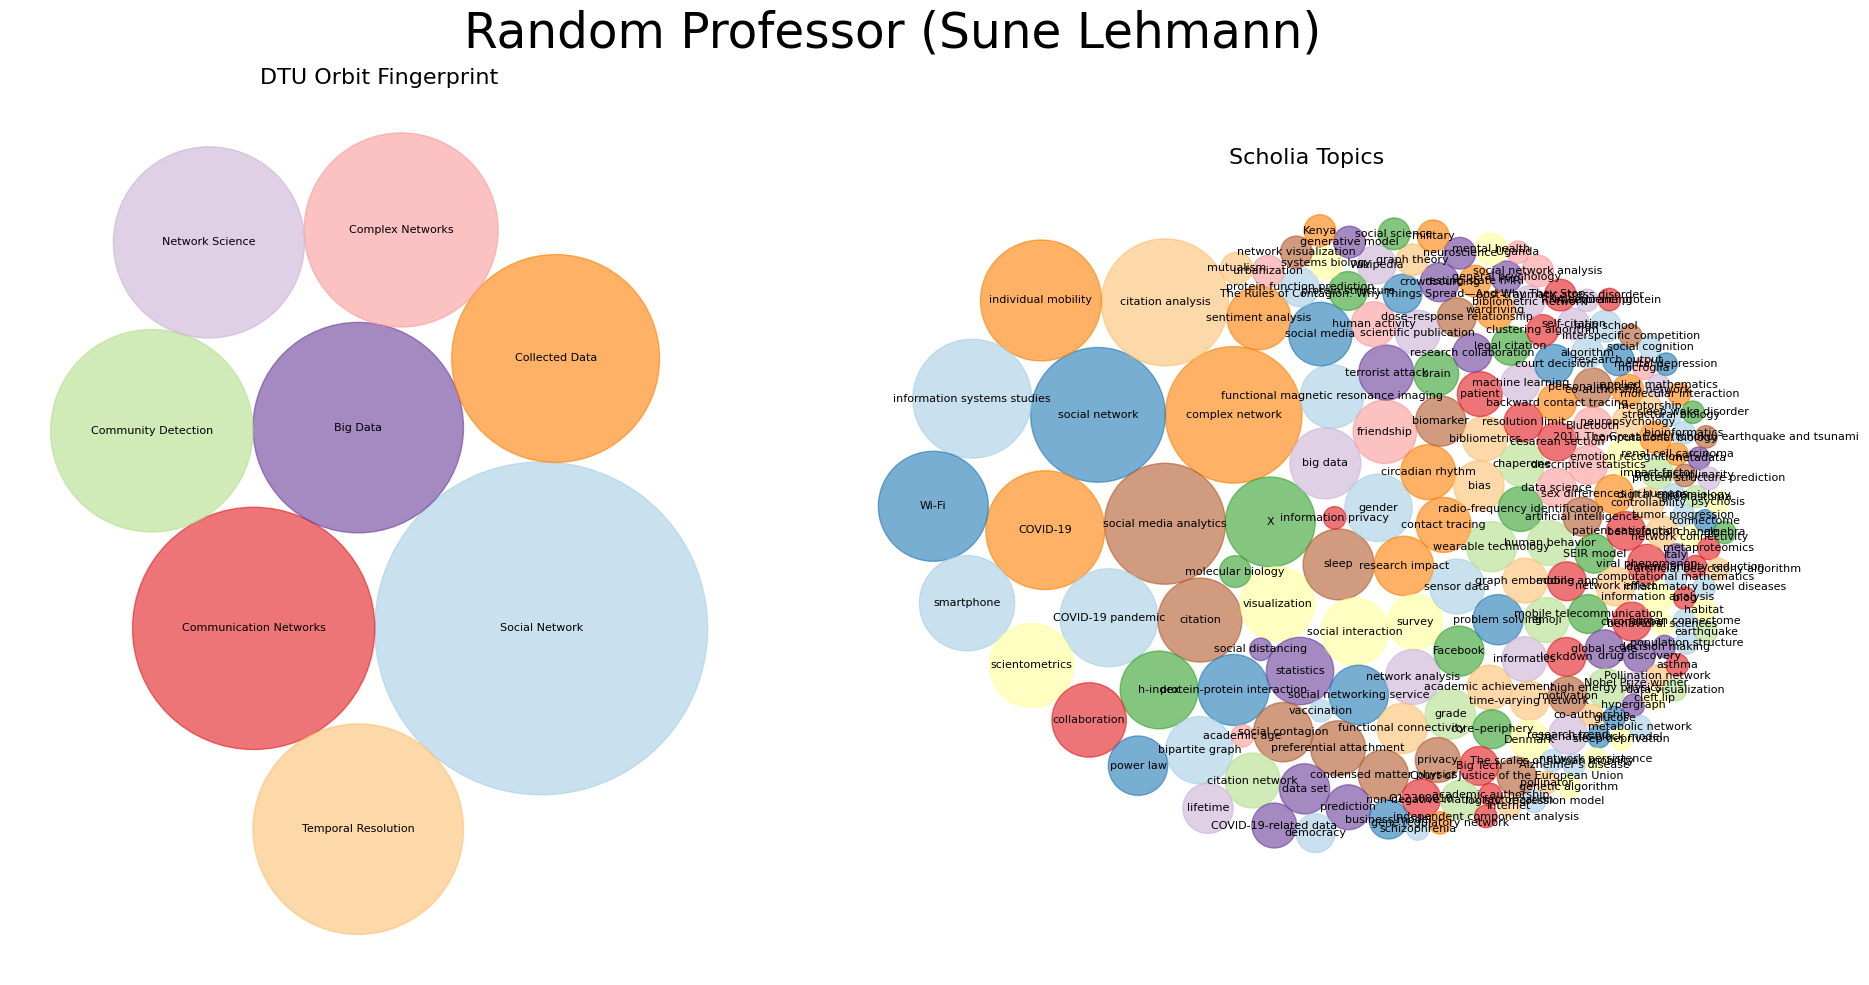

In [17]:
import circlify

# Calculate axis limits dynamically for a set of circles
def calculate_limits(circles, padding=0.1):
    x_min = min(circle.x - circle.r for circle in circles)
    x_max = max(circle.x + circle.r for circle in circles)
    y_min = min(circle.y - circle.r for circle in circles)
    y_max = max(circle.y + circle.r for circle in circles)
    return x_min - padding, x_max + padding, y_min - padding, y_max + padding

# Function to map circles back to their correct data
def remap_circles(circles, sizes, concepts):
    # Sort circles by radius (descending)
    sorted_circles = sorted(circles, key=lambda c: c.r, reverse=True)
    # Sort sizes and concepts by size (descending)
    sorted_data = sorted(zip(sizes, concepts), key=lambda x: x[0], reverse=True)
    sorted_sizes, sorted_concepts = zip(*sorted_data)
    return sorted_circles, sorted_concepts

# First dataset
data_1 = professors_data["Sune Lehmann Jørgensen"]["Fingerprint"]
data_2 = professors_data["Sune Lehmann Jørgensen"]["scholia_topics"]

concepts_1 = [item['Concept'] for item in data_1]
sizes_1 = [float(item['Value'].strip('%')) for item in data_1]
concepts_2 = [item['topic'] for item in data_2]
sizes_2 = [item['score'] for item in data_2]

# Calculate circles for both datasets
circles_1 = circlify.circlify(sizes_1, target_enclosure=circlify.Circle(x=0, y=0, r=1))
circles_2 = circlify.circlify(sizes_2, target_enclosure=circlify.Circle(x=0, y=0, r=1))

# Remap circles to correct sizes and concepts
circles_1, concepts_1 = remap_circles(circles_1, sizes_1, concepts_1)
circles_2, concepts_2 = remap_circles(circles_2, sizes_2, concepts_2)

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
plt.suptitle("Random Professor (Sune Lehmann)", fontsize=35, y=0.98)

# Plot first dataset
axes[0].axis('off')
axes[0].set_aspect('equal')

x_min, x_max, y_min, y_max = calculate_limits(circles_1)
axes[0].set_xlim(x_min, x_max)
axes[0].set_ylim(y_min, y_max)

for circle, concept in zip(circles_1, concepts_1):
    x, y, r = circle.x, circle.y, circle.r
    axes[0].add_patch(plt.Circle((x, y), r, alpha=0.6, color=plt.cm.Paired(hash(concept) % 12)))
    axes[0].text(x, y, concept, fontsize=8, ha='center', va='center')
axes[0].set_title("DTU Orbit Fingerprint", fontsize=16)

# Plot second dataset
axes[1].axis('off')
axes[1].set_aspect('equal')

x_min, x_max, y_min, y_max = calculate_limits(circles_2)
axes[1].set_xlim(x_min, x_max)
axes[1].set_ylim(y_min, y_max)

for circle, concept in zip(circles_2, concepts_2):
    x, y, r = circle.x, circle.y, circle.r
    axes[1].add_patch(plt.Circle((x, y), r, alpha=0.6, color=plt.cm.Paired(hash(concept) % 12)))
    axes[1].text(x, y, concept, fontsize=8, ha='center', va='center')
axes[1].set_title("Scholia Topics", fontsize=16)

plt.tight_layout()
plt.show()

### Explaratory Data Analysis of the Network

- Lecture 1, 2, 3, 4, 5

In [18]:
# Colors for plots (DTU Colours)
RED = '#990000'
BLUE = '#2F3EEA'
GREEN = '#1FD082'
NAVY = '#030F4F'
YELLOW = '#F6D04D'
ORANGE = '#FC7634'
SALMON = '#E83F48'
PURPLE = '#79238E'
DARKGREEN= '#008835'

plt.style.use('default')
plt.rcParams['font.family'] = 'serif'
plt.rcParams.update({'font.size': 12})

#### Create Bipartite Graph

In [19]:
B = nx.Graph()

professors = extract_professors(course_df, professor_columns)
courses = course_df["COURSE"].unique()
# professors.remove("NO_DATA")

B.add_nodes_from(professors, bipartite=0, type="Professor")  # Professors
B.add_nodes_from(courses, bipartite=1, type="Course")  # Courses

# Add edges based on professor-course relationships
for _, row in course_df.iterrows():
    course = row["COURSE"]
    for col in professor_columns:
        professor = row[col]
        if pd.notna(professor) and professor != "NO_DATA":
            B.add_edge(professor, course)

# Add metadata to nodes
for professor in professors:
    if professor in professors_data:
        # Add professor metadata (e.g., research areas)
        B.nodes[professor]["Profile_desc"] = professors_data[professor].get(
            "Profile_desc", None
        )
        B.nodes[professor]["Keywords"] = professors_data[professor].get("Keywords", [])
        B.nodes[professor]["Fingerprint"] = professors_data[professor].get(
            "Fingerprint", []
        )
        B.nodes[professor]["scholia_topics"] = professors_data[professor].get(
            "scholia_topics", []
        )

for _, row in course_df.iterrows():
    course = row["COURSE"]
    # Add course metadata (e.g., description and objectives)
    B.nodes[course]["COURSE_DESCRIPTION"] = row.get("COURSE_DESCRIPTION", "")
    B.nodes[course]["LEARNING_OBJECTIVES"] = row.get("LEARNING_OBJECTIVES", "")
    B.nodes[course]["COURSE_CONTENT"] = row.get("COURSE_CONTENT", "")
    B.nodes[course]["AVERAGE_GRADE"] = row.get("AVERAGE_GRADE", "")
    B.nodes[course]["RATING_AVERAGE_SCORE"] = row.get("RATING_AVERAGE_SCORE", "")

# check if a course does not have any professors
for course in courses:
    if B.degree(course) == 0:
        B.remove_node(course)
        courses = np.delete(courses, np.where(courses == course))

print(
    f"Bipartite graph created with {B.number_of_nodes()} nodes and {B.number_of_edges()} edges."
)

Bipartite graph created with 2751 nodes and 3143 edges.


In [20]:
# Select 5 courses from the courses set
selected_courses = random.sample(list(courses), 5)

# Create a subgraph with the selected courses and their connected professors
subgraph_nodes = set(selected_courses)
for course in selected_courses:
    subgraph_nodes.update(B.neighbors(course))

subgraph = B.subgraph(subgraph_nodes)

# Print the number of nodes and edges in the subgraph
print(f"Subgraph created with {subgraph.number_of_nodes()} nodes and {subgraph.number_of_edges()} edges.")
# Plot the subgraph
plt.figure(figsize=(12, 8))
pos = bipartite_layout(subgraph, selected_courses)

# Draw the nodes
nx.draw_networkx_nodes(
    subgraph,
    pos,
    nodelist=selected_courses,
    node_color=blue,
    node_size=100,
    label="Courses",
)
nx.draw_networkx_nodes(
    subgraph,
    pos,
    nodelist=set(subgraph) - set(selected_courses),
    node_color=orange,
    node_size=100,
    label="Professors",
)

# Draw the edges
nx.draw_networkx_edges(subgraph, pos, alpha=0.8, width=1)

# Add a legend
plt.legend(scatterpoints=1, loc="upper left")

# Draw the labels
nx.draw_networkx_labels(subgraph, pos, font_size=10)

# Add title
plt.title("Subgraph of Selected Courses and Connected Professors")

# Remove axis
plt.axis("off")

# Show the plot
plt.show()

Subgraph created with 21 nodes and 16 edges.


NameError: name 'blue' is not defined

<Figure size 1200x800 with 0 Axes>

In [ ]:
# Convert the bipartite graph to directed graph
B_directed = B.to_directed()
in_degrees = B_directed.in_degree()
out_degrees = B_directed.out_degree()
# get and load the statistics package

professors = {node for node, data in B_directed.nodes(data=True) if data['bipartite'] == 0}
courses = {node for node, data in B_directed.nodes(data=True) if data['bipartite'] == 1}

professor_in_degrees = [in_degrees[professor] for professor in professors]
course_in_degrees = [in_degrees[course] for course in courses]
professor_out_degrees = [out_degrees[professor] for professor in professors]
course_out_degrees = [out_degrees[course] for course in courses]

professor_in_avg = sum(professor_in_degrees) / len(professor_in_degrees) 
professor_in_median = statistics.median(professor_in_degrees) 
professor_in_mode = statistics.mode(professor_in_degrees) 
professor_in_min = min(professor_in_degrees) 
professor_in_max = max(professor_in_degrees)

course_in_avg = sum(course_in_degrees) / len(course_in_degrees)
course_in_median = statistics.median(course_in_degrees)
course_in_mode = statistics.mode(course_in_degrees)
course_in_min = min(course_in_degrees)
course_in_max = max(course_in_degrees)

professor_out_avg = sum(professor_out_degrees) / len(professor_out_degrees) 
professor_out_median = statistics.median(professor_out_degrees)
professor_out_mode = statistics.mode(professor_out_degrees) 
professor_out_min = min(professor_out_degrees) 
professor_out_max = max(professor_out_degrees) 

course_out_avg = sum(course_out_degrees) / len(course_out_degrees) 
course_out_median = statistics.median(course_out_degrees) 
course_out_mode = statistics.mode(course_out_degrees) 
course_out_min = min(course_out_degrees) 
course_out_max = max(course_out_degrees)

print(f"{'Professor In-Degree Statistics'} : Average = {professor_in_avg:.2f}, Median = {professor_in_median}, Mode = {professor_in_mode}, Min = {professor_in_min}, Max = {professor_in_max}")
print(f"{'Course In-Degree Statistics'} : Average = {course_in_avg:.2f}, Median = {course_in_median}, Mode = {course_in_mode}, Min = {course_in_min}, Max = {course_in_max}")
print(f"{'Professor Out-Degree Statistics'} : Average = {professor_out_avg:.2f}, Median = {professor_out_median}, Mode = {professor_out_mode}, Min = {professor_out_min}, Max = {professor_out_max}")
print(f"{'Course Out-Degree Statistics'} : Average = {course_out_avg:.2f}, Median = {course_out_median}, Mode = {course_out_mode}, Min = {course_out_min}, Max = {course_out_max}")

plt.figure(figsize=(14, 7))

# In-Degree Distribution
plt.subplot(1, 2, 1)
plt.hist(professor_in_degrees, bins=15, color=RED, label='Professors In-Degree', edgecolor='black')
plt.hist(course_in_degrees, bins=15, color=BLUE, label='Courses In-Degree', edgecolor='black')
plt.legend(loc='upper right', fontsize=12)
plt.title("In-Degree Distribution", fontsize=16)
plt.xlabel('In-Degree', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)

# Out-Degree Distribution
plt.subplot(1, 2, 2)
plt.hist(professor_out_degrees, bins=15, color=RED, label='Professors Out-Degree', edgecolor='black')
plt.hist(course_out_degrees, bins=15, color=BLUE, label='Courses Out-Degree', edgecolor='black')
plt.legend(loc='upper right', fontsize=12)
plt.title("Out-Degree Distribution", fontsize=16)
plt.xlabel('Out-Degree', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)

plt.suptitle("Degree Distribution of Professors and Courses", fontsize=18)
plt.tight_layout()
plt.show()

In [ ]:
# Function to calculate the size of the Giant Connected Component (GCC)
def get_gcc_size(graph):
    components = list(nx.connected_components(graph))
    largest_component = max(components, key=len)
    return len(largest_component)

# Generate a random Erdős–Rényi network with the same number of nodes and edges
n = len(B.nodes)  # Number of nodes
m = len(B.edges)  # Number of edges
random_graph = nx.erdos_renyi_graph(n, m / (n * (n - 1)))
scale_free_graph = nx.barabasi_albert_graph(n, 2)

# Calculate the GCC size for each network
gcc_bipartite_size = get_gcc_size(B)
gcc_random_size = get_gcc_size(random_graph)
gcc_scale_free_size = get_gcc_size(scale_free_graph)

# Calculate the network density for each graph
density_bipartite = nx.density(B)
density_random = nx.density(random_graph)
density_scale_free = nx.density(scale_free_graph)

plt.figure(figsize=(16, 12))

# Degree distribution for Bipartite Network
plt.subplot(2, 3, 1)
plt.hist([d for n, d in B.degree()], bins=15, color=green, alpha=0.7, edgecolor='black')
plt.title("Degree Distribution - Professor/Courses Network")
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)

# Degree distribution for Random Network
plt.subplot(2, 3, 2)
plt.hist([d for n, d in random_graph.degree()], bins=15, color=red, alpha=0.7, edgecolor='black')
plt.title("Degree Distribution - Random Network")
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)

# Degree distribution for Scale-Free Network
plt.subplot(2, 3, 3)
plt.hist([d for n, d in scale_free_graph.degree()], bins=15, color=purple, alpha=0.7, edgecolor='black')
plt.title("Degree Distribution - Scale-Free Network")
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)

plt.suptitle("Degree Distribution and GCC for Various Networks", fontsize=18)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(8, 4)) 

# Network Density Comparison
axes[0].bar(['Professor/Courses', 'Random', 'Scale-Free'], 
            [density_bipartite, density_random, density_scale_free], 
            color=[green, red, purple])
axes[0].set_title("Network Density Comparison")
axes[0].set_ylabel("Density")
axes[0].tick_params(axis='x', rotation=0) 

# GCC Size Comparison
axes[1].bar(['Professor/Courses', 'Random', 'Scale-Free'], 
            [gcc_bipartite_size, gcc_random_size, gcc_scale_free_size], 
            color=[green, red, purple])
axes[1].set_title("GCC Size Comparison")
axes[1].set_ylabel("GCC Size")
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

In [ ]:
# Compute degree centrality for the directed graph
degree_centrality = nx.degree_centrality(B_directed)
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
top_5_degree = sorted_degree[:5]

# Compute betweenness centrality for the directed graph
betweenness_centrality = nx.betweenness_centrality(B_directed)
sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
top_5_betweenness = sorted_betweenness[:5]

# Display the results
print("\nTop 5 Most Central Nodes by Degree Centrality:")
print("-" * 100)
for node, centrality in top_5_degree:
    print(f"Node: {node:<50} Degree Centrality: {centrality:.4f}")
print("\nTop 5 Most Central Nodes by Betweenness Centrality:")
print("-" * 100)
for node, centrality in top_5_betweenness:
    print(f"Node: {node:<50} Betweenness Centrality: {centrality:.4f}")

In [ ]:
degree_values = list(degree_centrality.values())
betweenness_values = list(betweenness_centrality.values())

# Calculate correlation coefficient
correlation_matrix = np.corrcoef(degree_values, betweenness_values)
correlation = correlation_matrix[0, 1]

plt.figure(figsize=(8, 6))
plt.scatter(degree_values, betweenness_values, alpha=0.7, color=YELLOW)

plt.title("Degree Centrality vs Betweenness Centrality", fontsize=16)
plt.xlabel("Degree Centrality", fontsize=14)
plt.ylabel("Betweenness Centrality", fontsize=14)
plt.text(0.55, 0.95, f"Correlation: {correlation:.2f}", 
         transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Exploratory Data analysis of Text

- Lecture 5, 6, 7, 8

In [ ]:
# Week 6
# Calculate lexical diversity for each course description and plot the distribution
course_df["COURSE_DESCRIPTION"] = course_df["COURSE_DESCRIPTION"].fillna("")
lens = course_df["COURSE_DESCRIPTION"].apply(len)
words = course_df["COURSE_DESCRIPTION"].apply(lambda x: len(x.split()))

lexical_diversity = words / lens

plt.figure(figsize=(12, 6))
plt.hist(lexical_diversity, bins=50, color=RED, edgecolor="black")
plt.title("Distribution of Lexical Diversity in Course Descriptions")
plt.xlabel("Lexical Diversity")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
# Week 7
from fa2_modified import ForceAtlas2
from collections import defaultdict, Counter
import matplotlib.cm as cm
import community as community_louvain

# Partition the graph using the Louvain method
partition = community_louvain.best_partition(B)

# Calculate the modularity
modularity_value = community_louvain.modularity(partition, B)

print(f"Modularity of the partition: {modularity_value}")

forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=True,
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,
    jitterTolerance=1.0,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=1.0,
    verbose=True,
)
positions = forceatlas2.forceatlas2_networkx_layout(B, iterations=2000)

# **Partition by Louvain Method**
louvain_partition = community_louvain.best_partition(B)

community_sizes = Counter(louvain_partition.values())
largest_communities = sorted(community_sizes, key=community_sizes.get, reverse=True)[
    :10
]
colors = cm.rainbow(np.linspace(0, 1, len(largest_communities)))

# set node colors
node_colors_louvain = []
for node in B.nodes():
    community_id = louvain_partition[node]
    if community_id in largest_communities:
        color_index = largest_communities.index(community_id)
        node_colors_louvain.append(colors[color_index])
    else:
        node_colors_louvain.append("lightgray")


plt.title("Louvain Community Partition")
nx.draw_networkx_nodes(
    B,
    pos=positions,
    node_color=node_colors_louvain,
    node_size=20,
    alpha=0.4,
)
nx.draw_networkx_edges(B, pos=positions, edge_color="lightgray", alpha=0.5)
plt.axis("off")

plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from bs4 import BeautifulSoup


# Function to remove HTML tags
def clean_html(text):
    return BeautifulSoup(text, "html.parser").get_text()


# Group course nodes by institute
institute_courses = course_df.groupby("INSTITUTE")["COURSE"].apply(list).to_dict()

# Combine course descriptions and learning objectives, and remove HTML tags
course_df["TEXT"] = (course_df["COURSE_DESCRIPTION"].fillna("")).apply(clean_html)

# Create a dictionary to store the combined text for each institute
institute_texts = {
    inst: " ".join(course_df[course_df["COURSE"].isin(courses)]["TEXT"])
    for inst, courses in institute_courses.items()
}

# Perform TF-IDF
vectorizer = TfidfVectorizer(stop_words="english")
tfidf_matrix = vectorizer.fit_transform(institute_texts.values())
feature_names = vectorizer.get_feature_names_out()

# Create word clouds for each institute in a nxm subplot
n = 6  # number of rows
m = 3  # number of columns
fig, axes = plt.subplots(n, m, figsize=(20, 10))

for ax, (idx, inst) in zip(axes.flatten(), enumerate(institute_texts.keys())):
    tfidf_scores = tfidf_matrix[idx].toarray().flatten()
    tfidf_dict = dict(zip(feature_names, tfidf_scores))

    wordcloud = WordCloud(
        width=800, height=400, background_color="white"
    ).generate_from_frequencies(tfidf_dict)

    ax.imshow(wordcloud, interpolation="bilinear")
    ax.set_title(f"Word Cloud for {inst}")
    ax.axis("off")

plt.tight_layout()
plt.show()

### Main Analysis and our Methodology

### NLP approach

In [26]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import json

# Load Data
with open("data/all_professors.json", "r") as f:
    professors_data = json.load(f)

file_path = 'data/course_df.csv'
course_df = pd.read_csv(file_path)

# Download NLTK data (if not already downloaded)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('omw-1.4', quiet=True)

# Define preprocessing functions
def preprocess_term(term):
    # Lowercase
    term = term.lower()
    # Remove punctuation
    term = term.translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    tokens = nltk.word_tokenize(term)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into a string
    preprocessed_term = ' '.join(tokens)
    return preprocessed_term

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Remove punctuation and non-alphabetic tokens
    tokens = [word for word in tokens if word.isalpha()]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into a string
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

# Function to preprocess and extract concepts from text
def extract_keywords(text):
    # Tokenize text
    tokens = nltk.word_tokenize(text)
    # Lowercase and lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens if token.isalpha()]

    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

### Simple bag of words

In [27]:
# Prepare professors' concept vectors
professors_concepts = {}
all_concepts = set()

for prof, data in professors_data.items():
    concepts = []
    # Extract concepts from Fingerprint
    for item in data.get('Fingerprint', []):
        concepts.append(item['Concept'])
    # Extract topics from scholia_topics
    for item in data.get('scholia_topics', []):
        concepts.append(item['topic'])
    # Preprocess concepts
    concepts = [concept.lower() for concept in concepts]
    professors_concepts[prof] = concepts
    all_concepts.update(concepts)

# Prepare courses' concept vectors
courses_concepts = {}
for idx, row in course_df.iterrows():
    course_text = ' '.join([
        row['COURSE_DESCRIPTION'],
        row['LEARNING_OBJECTIVES'],
        row['COURSE_CONTENT'],
    ])
    concepts = extract_keywords(course_text)
    courses_concepts[row['COURSE']] = concepts
    all_concepts.update(concepts)

# Create a list of all unique concepts
all_concepts = list(all_concepts)

# Create concept vectors for professors
professors_vectors = []
for prof in professors_data.keys():
    vector = [0] * len(all_concepts)
    prof_concepts = professors_concepts[prof]
    for concept in prof_concepts:
        if concept in all_concepts:
            idx = all_concepts.index(concept)
            vector[idx] += 1  
    professors_vectors.append(vector)

# Create concept vectors for courses
courses_vectors = []
for course in course_df['COURSE']:
    vector = [0] * len(all_concepts)
    course_concepts = courses_concepts[course]
    for concept in course_concepts:
        if concept in all_concepts:
            idx = all_concepts.index(concept)
            vector[idx] += 1
    courses_vectors.append(vector)

# Convert vectors to numpy arrays
professors_vectors = np.array(professors_vectors)
courses_vectors = np.array(courses_vectors)

# Compute similarity matrix
similarity_matrix = cosine_similarity(professors_vectors, courses_vectors)

# Create DataFrame for similarity scores
bog_similarity_df = pd.DataFrame(
    similarity_matrix,
    index=professors_data.keys(),
    columns=course_df['COURSE']
)

### Unweighted TF-IDF

In [28]:
# Prepare professors' text data
professors_text = {}
for prof, data in professors_data.items():
    # Combine all textual information
    text_parts = []
    # Add Profile Description
    profile_desc = data.get('Profile_desc', '')
    text_parts.append(profile_desc)
    # Add Fingerprint Concepts
    fingerprint_concepts = [item['Concept'] for item in data.get('Fingerprint', [])]
    text_parts.extend(fingerprint_concepts)
    # Add Scholia Topics
    scholia_topics = [item['topic'] for item in data.get('scholia_topics', [])]
    text_parts.extend(scholia_topics)
    # Combine into one text
    full_text = ' '.join(text_parts)
    # Preprocess the text
    preprocessed_text = preprocess_text(full_text)
    professors_text[prof] = preprocessed_text

# Prepare courses' text data
courses_text = {}
for idx, row in course_df.iterrows():
    # Combine course descriptions
    text_parts = [
        row.get('COURSE_DESCRIPTION', ''),
        row.get('LEARNING_OBJECTIVES', ''),
        row.get('COURSE_CONTENT', '')
    ]
    full_text = ' '.join(text_parts)
    # Preprocess the text
    preprocessed_text = preprocess_text(full_text)
    courses_text[row['COURSE']] = preprocessed_text

# Combine all texts
all_texts = list(professors_text.values()) + list(courses_text.values())

# Initialize and fit the TF-IDF Vectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit(all_texts)

# Transform texts into TF-IDF vectors
professors_vectors = vectorizer.transform(professors_text.values())
courses_vectors = vectorizer.transform(courses_text.values())

# Compute similarity matrix
similarity_matrix = cosine_similarity(professors_vectors, courses_vectors)

# Create DataFrame for similarity scores
unweighted_tfidf_similarity_df = pd.DataFrame(
    similarity_matrix,
    index=professors_text.keys(),
    columns=courses_text.keys()
)

### Weighted TF-IDF by fingerprints and scholia topics

In [34]:
# Prepare professors' term frequencies with weights
professors_term_weights = {}
all_terms = set()

for prof, data in professors_data.items():
    term_weights = {}
    # Extract 'Fingerprint' concepts and their weights
    for item in data.get('Fingerprint', []):
        term = preprocess_term(item['Concept'])
        value_str = item.get('Value', '0%').strip('%')
        weight = float(value_str)  # Convert percentage string to float
        term_weights[term] = term_weights.get(term, 0) + weight
        all_terms.add(term)
    # Extract 'scholia_topics' and their scores
    for item in data.get('scholia_topics', []):
        term = preprocess_term(item['topic'])
        weight = float(item.get('score', 0))
        term_weights[term] = term_weights.get(term, 0) + weight
        all_terms.add(term)
    professors_term_weights[prof] = term_weights

# Prepare courses' text data
course_texts = []
course_names = []

for idx, row in course_df.iterrows():
    # Combine course descriptions
    text_parts = [
        row.get('COURSE_DESCRIPTION', ''),
        row.get('LEARNING_OBJECTIVES', ''),
        row.get('COURSE_CONTENT', '')
    ]
    full_text = ' '.join(text_parts)
    # Preprocess the text
    preprocessed_text = preprocess_text(full_text)
    course_texts.append(preprocessed_text)
    course_names.append(row['COURSE'])

# Build the vocabulary
vectorizer_for_vocab = CountVectorizer()
vectorizer_for_vocab.fit(course_texts)
course_terms = set(vectorizer_for_vocab.get_feature_names_out())

vocabulary = list(all_terms.union(course_terms))

# Vectorize courses
vectorizer = CountVectorizer(vocabulary=vocabulary)
course_term_counts = vectorizer.transform(course_texts)

tfidf_transformer = TfidfTransformer()
course_tfidf = tfidf_transformer.fit_transform(course_term_counts)

# Vectorize professors with weights
professors_term_counts = []
professor_names = []

for prof in professors_data.keys():
    term_weights = professors_term_weights[prof]
    term_count_vector = [0.0] * len(vocabulary)
    for term, weight in term_weights.items():
        if term in vocabulary:
            idx = vocabulary.index(term)
            term_count_vector[idx] = weight
    professors_term_counts.append(term_count_vector)
    professor_names.append(prof)

professors_term_counts = np.array(professors_term_counts)

professors_tfidf = tfidf_transformer.transform(professors_term_counts)

# Compute cosine similarity
similarity_matrix = cosine_similarity(professors_tfidf, course_tfidf)

# Create DataFrame for similarity scores
weighted_tfidf_similarity_df = pd.DataFrame(
    similarity_matrix,
    index=professor_names,
    columns=course_names
)


### Weighted normalized TF-IDF by fingerprints and scholia topics

In [35]:
# Prepare professors' term frequencies with weights
professors_term_weights = {}
all_terms = set()

for prof, data in professors_data.items():
    term_weights = {}
    # Extract 'Fingerprint' concepts and their weights
    for item in data.get('Fingerprint', []):
        term = preprocess_term(item['Concept'])
        value_str = item.get('Value', '0%').strip('%')
        weight = float(value_str)  # Convert percentage string to float
        term_weights[term] = term_weights.get(term, 0) + weight
        all_terms.add(term)
    # Extract 'scholia_topics' and their scores
    for item in data.get('scholia_topics', []):
        term = preprocess_term(item['topic'])
        weight = float(item.get('score', 0))
        term_weights[term] = term_weights.get(term, 0) + weight
        all_terms.add(term)
    professors_term_weights[prof] = term_weights

# Normalize professors' weights per professor individually
from sklearn.preprocessing import MinMaxScaler

for prof in professors_term_weights:
    term_weights = professors_term_weights[prof]
    weights = np.array(list(term_weights.values())).reshape(-1, 1)
    if not term_weights:
        continue
    # Proceed with normalization and the rest of the code
    # Check if all weights are the same
    if np.all(weights == weights[0]):
        # If all weights are the same, set them to a constant value (e.g., 1)
        normalized_weights = np.ones_like(weights).flatten()
    else:
        scaler = MinMaxScaler(feature_range=(1, 15))
        normalized_weights = scaler.fit_transform(weights).flatten()
    # Map normalized weights back to terms
    for idx, term in enumerate(term_weights):
        term_weights[term] = normalized_weights[idx]

# Prepare courses' text data
course_texts = []
course_names = []

for idx, row in course_df.iterrows():
    # Combine course descriptions
    text_parts = [
        row.get('COURSE_DESCRIPTION', ''),
        row.get('LEARNING_OBJECTIVES', ''),
        row.get('COURSE_CONTENT', '')
    ]
    full_text = ' '.join(text_parts)
    # Preprocess the text
    preprocessed_text = preprocess_text(full_text)
    course_texts.append(preprocessed_text)
    course_names.append(row['COURSE'])

# Build the vocabulary
vectorizer_for_vocab = CountVectorizer()
vectorizer_for_vocab.fit(course_texts)
course_terms = set(vectorizer_for_vocab.get_feature_names_out())

vocabulary = list(all_terms.union(course_terms))

# Vectorize courses
vectorizer = CountVectorizer(vocabulary=vocabulary)
course_term_counts = vectorizer.transform(course_texts)

# Vectorize professors with normalized weights
professors_term_counts = []
professor_names = []

for prof in professors_data.keys():
    term_weights = professors_term_weights[prof]
    term_count_vector = [0.0] * len(vocabulary)
    for term, weight in term_weights.items():
        if term in vocabulary:
            idx = vocabulary.index(term)
            term_count_vector[idx] = weight
    professors_term_counts.append(term_count_vector)
    professor_names.append(prof)

professors_term_counts = np.array(professors_term_counts)

# Combine term-frequency matrices
combined_term_counts = np.vstack([professors_term_counts, course_term_counts.toarray()])

# Apply TF-IDF transformation on combined data
tfidf_transformer = TfidfTransformer()
combined_tfidf = tfidf_transformer.fit_transform(combined_term_counts)

# Extract TF-IDF vectors
num_professors = len(professors_data)
professors_tfidf = combined_tfidf[:num_professors]
courses_tfidf = combined_tfidf[num_professors:]

# Compute cosine similarity
similarity_matrix = cosine_similarity(professors_tfidf, courses_tfidf)

# Create DataFrame for similarity scores
weighted_normalized_tfidf_similarity_df = pd.DataFrame(
    similarity_matrix,
    index=professor_names,
    columns=course_names
)

### 2) "Does the alignment between professors’ research and the courses they teach influence student satisfaction and performance (grades)?"

In [40]:
similarity_df = unweighted_tfidf_similarity_df

course_grades = {course: B.nodes[course].get('AVERAGE_GRADE', None) for course in B.nodes}
course_ratings = {course: B.nodes[course].get('RATING_AVERAGE_SCORE', None) for course in B.nodes}

# Create DF with professor, course, alignment_score, and average_grade
professor_course_alignment_grade_df = similarity_df.stack().reset_index()
professor_course_alignment_grade_df.columns = ['professor', 'course', 'alignment_score']
professor_course_alignment_grade_df['average_grade'] = professor_course_alignment_grade_df['course'].map(course_grades)

# Create DF with professor, course, alignment_score, and rating_average_score
professor_course_alignment_rating_df = similarity_df.stack().reset_index()
professor_course_alignment_rating_df.columns = ['professor', 'course', 'alignment_score']
professor_course_alignment_rating_df['rating_average_score'] = professor_course_alignment_rating_df['course'].map(course_ratings)

# Filter out rows with 'Pass/Fail' or 'No data'
professor_course_alignment_grade_df = professor_course_alignment_grade_df[~professor_course_alignment_grade_df['average_grade'].isin(['Pass/Fail', 'No data'])]
professor_course_alignment_rating_df = professor_course_alignment_rating_df[~professor_course_alignment_rating_df['rating_average_score'].isin(['Pass/Fail', 'No data'])]

# Correlation analysis for alignment_score and average_grade
correlation = professor_course_alignment_grade_df['alignment_score'].corr(professor_course_alignment_grade_df['average_grade'])
print(f"Correlation between alignment score and average grade: {correlation}")

# Correlation analysis for alignment_score and rating_average_score
correlation = professor_course_alignment_rating_df['alignment_score'].corr(professor_course_alignment_rating_df['rating_average_score'])
print(f"Correlation between alignment score and rating average score: {correlation}")

Correlation between alignment score and average grade: -0.0053044352917387405
Correlation between alignment score and rating average score: -0.002518047089154551


### Results

### Conclusion